In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from preprocessing import vocab_size
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

In [4]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [6]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

### Model Definition

In [11]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [12]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [14]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [16]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [23]:
class EncoderClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, num_classes, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, \
                               vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.encoder(x)
        x = self.seq(x)
        logits = self.final_layer(x[:, 0, :])

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps,
        }
    
    def from_config(cls, config):
         return cls(**config)

In [25]:
#Doesn't work, don't run
class MultiGPU(tf.keras.optimizers.schedules.LearningRateSchedule):    
    def __init__(self, d_model, step_stages, step_mult, epochs_step):
        super().__init__()
        
        init_lr = np.array([
            #1-20: good, slightly high
            step_stages[0] * (4000 ** -1.5),
            #20-75: low
            step_stages[1] * (4000 ** -1.5),
            #75-120: good
            step_stages[2] * step_mult ** tf.math.floor(step_stages[2] / epochs_step),
            #120-200: low
            step_stages[3] * 0.08 * (4000 ** -1.5)])

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.step_stages = step_stages
        self.step_mult = step_mult
        self.epochs_step = epochs_step
        self.init_lr = init_lr
        

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        #print(step)
        #print(step.numpy)
        #print(np.array(step))
        step_stages = self.step_stages
        step_mult = self.step_mult
        epochs_step = self.epochs_step
        init_lr = self.init_lr
        
        #0-20: good, slightly high
        if np.array(step) < step_stages[1]:
            arg = step * (4000 ** -1.5)
        #20-75: low
        elif np.array(step) < step_stages[2]:
            initial = tf.cast(init_lr[1], dtype=tf.float32)
            arg = initial * step_mult[0] ** tf.math.floor(step / epochs_step)
        #75-120: good
        elif np.array(step) < step_stages[3]:
            arg = step * (4000 ** -1.5)
        #120+: low
        elif np.array(step) < step_stages[4]:
            initial =  tf.cast(init_lr[3], dtype=tf.float32)
            arg = initial * step_mult[1] ** tf.math.floor(step / epochs_step)
                    
        #arg1 = tf.math.rsqrt(step)
        #arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.cast(arg, tf.float32)
    
    def get_config(self):
        return {
            "d_model" : self.d_model,
            "step_stages" : self.step_stages,
            "step_mult" : self.step_mult,
            "epochs_step" : self.epochs_step,
            "init_lr" : self.init_lr,
        }
    
    def from_config(cls, config):
         return cls(**config)

### Model Training

In [8]:
num_layers = 4
d_model = 128
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 100
num_classes = len(np.unique(y_train))
batch_size = 64
multi_gpu = False #If true, distrubutes over all GPUS allocated. If false, runs on 1 gpu

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [26]:
def get_compiled_model():    
    #if(multi_gpu):
        #learning_rate = MultiGPU(d_model, 
                         #step_stages=np.array([1, 20, 75, 120, 200]), 
                         #step_mult=np.array([1.3, 1.2]), 
                         #epochs_step=10.0)
    #else:
    learning_rate = CustomSchedule(d_model)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [27]:
def define_workers(strategy):
    replicas = strategy.num_replicas_in_sync
    replica_batch = global_batch/replicas
    return replicas, replica_batch

In [28]:
def distribute_dataset(strategy):
    #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(global_batch)
    #val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(global_batch)
    #train_dataset = train_dataset.batch(global_batch)
    #val_dataset = val_dataset.batch(global_batch)

    train_dist = strategy.experimental_distribute_dataset(train_dataset)
    val_dist = strategy.experimental_distribute_dataset(val_dataset)
    return train_dist, val_dist

In [29]:
if(multi_gpu):
    #Create a MirroredStrategy.
    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))

    #Open a strategy scope.
    with strategy.scope():
        #Everything that creates variables should be under the strategy scope.
        #In general this is only model construction & `compile()`.
        model = get_compiled_model()

    replicas, replica_batch = define_workers(strategy)
    train_dist, val_dist = distribute_dataset(strategy)
else:
    model = get_compiled_model()

In [ ]:
if(multi_gpu):
    #Havings issues, doesn't return correct data. Evalutes in 2-3m thought
    history = model.fit(train_dist, batch_size=replica_batch, epochs=epochs, 
                        validation_data=val_dist, steps_per_epoch=replicas*8, validation_steps=replicas, verbose=1)
else:
    history = model.fit(train_dataset, batch_size=global_batch, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/100


2023-03-01 18:01:26.545409: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x49cc4b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-01 18:01:26.545460: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-01 18:01:26.553868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-01 18:01:26.669744: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


298/298 [==============================] - 23s 46ms/step - loss: 1.8787 - accuracy: 0.2640 - val_loss: 1.4435 - val_accuracy: 0.4062
Epoch 2/100
298/298 [==============================] - 8s 28ms/step - loss: 1.4411 - accuracy: 0.3957 - val_loss: 1.3997 - val_accuracy: 0.4091
Epoch 3/100
298/298 [==============================] - 8s 28ms/step - loss: 1.3880 - accuracy: 0.4087 - val_loss: 1.4279 - val_accuracy: 0.3986
Epoch 4/100
298/298 [==============================] - 8s 28ms/step - loss: 1.3784 - accuracy: 0.4119 - val_loss: 1.3612 - val_accuracy: 0.4264
Epoch 5/100
298/298 [==============================] - 8s 28ms/step - loss: 1.3590 - accuracy: 0.4256 - val_loss: 1.3738 - val_accuracy: 0.4243
Epoch 6/100
298/298 [==============================] - 9s 29ms/step - loss: 1.3445 - accuracy: 0.4251 - val_loss: 1.3931 - val_accuracy: 0.4226
Epoch 7/100
298/298 [==============================] - 9s 29ms/step - loss: 1.3369 - accuracy: 0.4319 - val_loss: 1.4007 - val_accuracy: 0.4062
Epo

In [81]:
#model.save("1gpu_batch64_epoch150_dmodel164_drop25")

In [82]:
#model = tf.saved_model.load("1gpu_batch48_epoch300_dmodel64_drop25")

### Training Plots

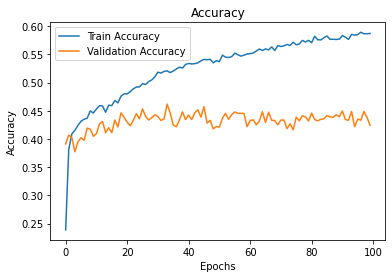

In [80]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

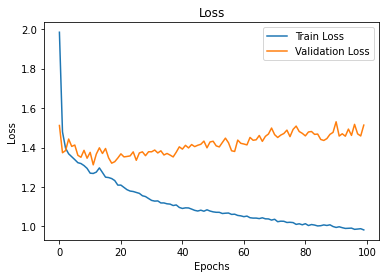

In [81]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

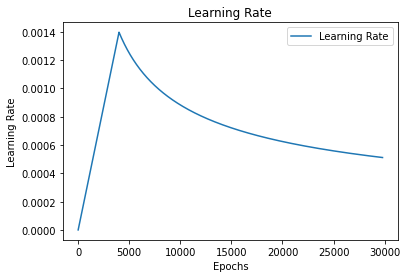

In [84]:
#learning_rate = MultiGPU(d_model, 
                         #step_stages=np.array([1, 20, 75, 120, 200]), 
                         #step_mult=np.array([1.3, 1.2]), 
                         #epochs_step=10.0)
learning_rate = CustomSchedule(d_model)
lr = np.array([])
for i in range(1, 29800):
    lr = np.append(lr, learning_rate.__call__(i))
    #print(learning_rate.__call__(i).numpy())
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
#plt.axis([0, 300, 0, 0.000125])
plt.legend()


### Model Evaluation

In [109]:
pred = model.predict(X_test)

75/75 [==============================] - 2s 12ms/step


In [110]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [111]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.4636401849516604
+-1 accuracy 0.8633879781420765
+-2 accuracy 0.9722572509457755


Heatmap

<AxesSubplot:>

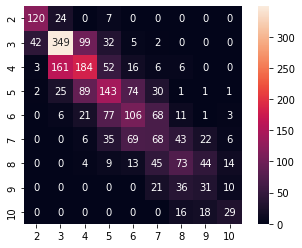

In [112]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

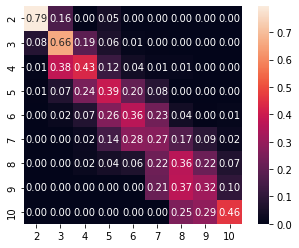

In [113]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)

In [114]:
GCNcm = np.array([
    [263, 58, 32, 7, 5, 3, 1, 2, 2, 0, 0],
    [175, 98, 64, 19, 22, 20, 4, 3, 6, 0, 4],
    [66, 132, 79, 25, 31, 29, 3, 16, 11, 0, 3],
    [29, 78, 62, 37, 53, 51, 36, 23, 6, 3, 13],
    [29, 55, 43, 24, 35, 62, 33, 63, 9, 2, 23],
    [10, 38, 46, 26, 62, 41, 73, 99, 11, 0, 12],
    [0, 25, 19, 19, 10, 34, 112, 158, 14, 6, 11],
    [45, 0, 63, 0, 27, 82, 0, 89, 59, 0, 0],
    [0, 0, 0, 0, 0, 0, 242, 87, 183, 86, 0],
    [0, 0, 0, 0, 0, 0, 141, 0, 133, 0, 126],
    [142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
#normalized_GCNcm = norm_cm(GCNcm)
print('accuracy', accuracy(GCNcm))
#print('accuracy', accuracy(normalized_GCNcm))
print('+-1 accuracy', top_1_accuracy(GCNcm))
#print('+-1 accuracy', top_1_accuracy(normalized_GCNcm))
print('+-2 accuracy', top_2_accuracy(GCNcm))
#print('+-2 accuracy', top_2_accuracy(normalized_GCNcm))

accuracy 0.21877188886294655
+-1 accuracy 0.5626897034788699
+-2 accuracy 0.7555451786131216
